In [1]:
from datasets import list_datasets, load_dataset
import torch

/home/kumarmg/anaconda3/envs/fastai/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import wandb

In [3]:
from fastai.data.all import *
from fastai.vision.all import *
from fastai.callback.wandb import *
# from fastai.distributed import *
# from accelerate import notebook_launcher
# from accelerate.utils import write_basic_config

In [4]:
import torchvision.transforms as transforms

In [13]:
from PIL import ImageFilter

In [5]:
path = Path('/home/kumarmg/dl_experiments/training imagenet from scratch')

In [6]:
class imagenet_dataset(Datasets):
    def __init__(self, hf_identifier = "imagenet-1k", use_auth_token = True):
        
        self.imagenet_ds = load_dataset(hf_identifier ,split='train', use_auth_token=use_auth_token)
        self.label_names = self.imagenet_ds.features['label'].names
#         super().__init__(items = self.imagenet_ds)
        
    
    def __len__(self): 
        return len(self.imagenet_ds)

    def __getitem__(self, n):
        data = self.imagenet_ds[n]
        return data['image'], data['label']

In [7]:
imagenet_ds = imagenet_dataset()

Found cached dataset imagenet-1k (/home/kumarmg/.cache/huggingface/datasets/imagenet-1k/default/1.0.0/a1e9bfc56c3a7350165007d1176b15e9128fcaf9ab972147840529aed3ae52bc)


In [8]:
random_split_pct = 0.8
train_ds_len = int(random_split_pct*len(imagenet_ds))
train_ds, val_ds = torch.utils.data.random_split(imagenet_ds, [train_ds_len, len(imagenet_ds)-train_ds_len])

In [9]:
class hf_imagenet_item_tfms: 
    '''hugginface datasets version of imagenet-1k gives PIL.JpegImagePlugin.JpegImageFile files. 
    Also some of the images are B&W (1 channel instead of 3 channel)
    Transforms to convert this dataset to usable tensors
    '''
    def __init__(self, tfms:list = None):
        self.tfms = list(tfms or [lambda img: img.convert(mode='RGB'),lambda img: img.resize((256, 256)), transforms.PILToTensor(), TensorImage])
    
    def __call__(self, x):
        "note that after_item takes output of create_item, which returns a tuple of x,y. So we need to return it as is."
        img, label = x
        ret = transforms.Compose(self.tfms)(img)
        return ret,label

class hf_imagenet_batch_tfms:
    def __init__(self, tfms:list = None):
        self.tfms = list(tfms or [IntToFloatTensor(), Normalize.from_stats(*imagenet_stats),  *aug_transforms()])
    
    def __call__(self, x): 
        "after_batch however, unlike after_item, takes on x as input"
        return transforms.Compose(self.tfms)(x)

In [10]:
train_dl = DataLoader(train_ds, bs = 128, shuffle = True, drop_last = True, 
                      after_item = hf_imagenet_item_tfms(),
                      after_batch =hf_imagenet_batch_tfms(),
#                     device = 'cuda:0',
                     )

val_dl = DataLoader(val_ds, bs = 256, shuffle = False, drop_last = True, 
                 after_item = hf_imagenet_item_tfms(),
                 after_batch =hf_imagenet_batch_tfms(),
#                 device = 'cuda:0',
                   )

dls = DataLoaders(train_dl, val_dl).cuda()
dls.vocab = imagenet_ds.label_names

top_5_accuracy = partial(top_k_accuracy, k=5)
top_10_accuracy = partial(top_k_accuracy, k=10)

learn = vision_learner(dls, xse_resnext50_deeper, loss_func = CrossEntropyLossFlat(), metrics=[accuracy,top_5_accuracy, top_10_accuracy], 
                       pretrained=False, normalize = False,
#                        cbs=WandbCallback(),
                      ).to_fp16()

learn.path = path

# with learn.distrib_ctx(sync_bn=False, in_notebook=True):
# learn.fine_tune(1)

# learn.export(path/"imagenet")
learn.summary()

Sequential (Input shape: 128 x 3 x 256 x 256)
Layer (type)         Output Shape         Param #    Trainable 
                     128 x 32 x 128 x 12 
Conv2d                                    864        True      
BatchNorm2d                               64         True      
ReLU                                                           
Conv2d                                    9216       True      
BatchNorm2d                               64         True      
ReLU                                                           
____________________________________________________________________________
                     128 x 64 x 128 x 12 
Conv2d                                    18432      True      
BatchNorm2d                               128        True      
ReLU                                                           
____________________________________________________________________________
                     128 x 64 x 64 x 64  
MaxPool2d                         

In [12]:
# wandb.init()
learn.lr_find()

KeyboardInterrupt: 

In [13]:
learn.save("imagenet_no_blur")

Path('/home/kumarmg/dl_experiments/training imagenet from scratch/models/imagenet_no_blur.pth')

In [ ]:
# learn = vision_learner(dls, resnet34, loss_func = CrossEntropyLossFlat(), metrics=accuracy, pretrained=False, normalize = False,
# #                        cbs=WandbCallback(),
#                       ).to_fp16()
# learn.path = path

# learn.load("imagenet_no_blur")

# Now, running blur experiments

we use gaussian blur with a randomized radius. We choose std = 1. Since we want most of our data within r=2 (95% data will be within 2`*`sigma), beyond which the image becomes too blurred

tensor([0.5181])


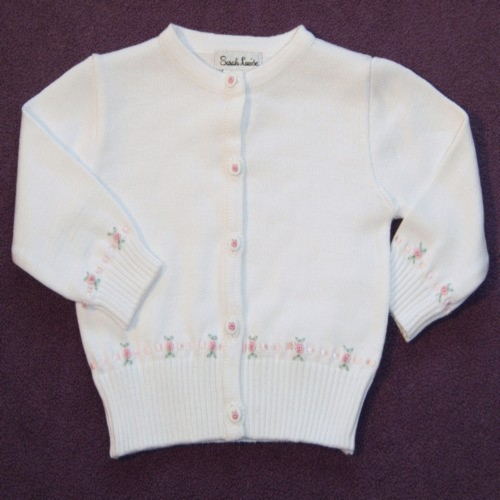

In [164]:
x,y = train_ds[int(random.random()*100)]
a = torch.normal(mean=Tensor([0]), std=Tensor([1]))
print(a)
x.filter(ImageFilter.GaussianBlur(radius = a))

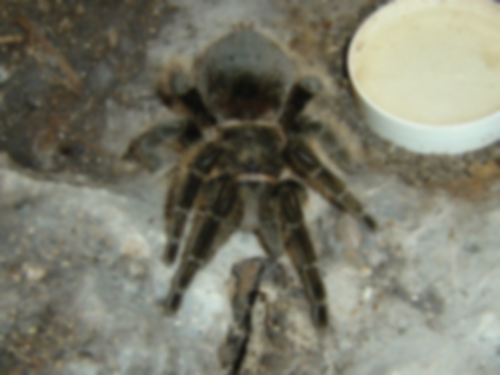

In [30]:
x.filter(ImageFilter.GaussianBlur(radius = 2))

putting this as a transform

In [284]:
class hf_imagenet_item_tfms: 
    '''hugginface datasets version of imagenet-1k gives PIL.JpegImagePlugin.JpegImageFile files. 
    Also some of the images are B&W (1 channel instead of 3 channel)
    Transforms to convert this dataset to usable tensors
    '''
    def __init__(self, tfms:list = None, blur: bool = False, blur_std = 1.):
        self.blur = blur
        self.blur_std = blur_std
        if blur: assert self.blur_std is not None 
            
        self.tfms = list(tfms or [lambda img: img.convert(mode='RGB'), self.apply_blur, lambda img: img.resize((256, 256)), 
                                  transforms.PILToTensor(), TensorImage])
    
    def apply_blur(self,x):
        radius = torch.normal(mean=Tensor([0]), std=Tensor([self.blur_std or 0]))
        print(radius)
        return x.filter(ImageFilter.GaussianBlur(radius = radius)) if self.blur else x
 
    def __call__(self, x):
        "note that after_item takes output of create_item, which returns a tuple of x,y. So we need to return it as is."
        img, label = x
        ret = transforms.Compose(self.tfms)(img)
        return ret,label
    
    

class hf_imagenet_batch_tfms:
    def __init__(self, tfms:list = None):
        self.tfms = list(tfms or [IntToFloatTensor(), Normalize.from_stats(*imagenet_stats),  *aug_transforms()])
    
    def __call__(self, x): 
        "after_batch however, unlike after_item, takes on x as input"
        return transforms.Compose(self.tfms)(x)

In [300]:
train_dl = DataLoader(train_ds, bs = 128, shuffle = True, drop_last = True, 
                      after_item = hf_imagenet_item_tfms(blur = True),
                      after_batch =hf_imagenet_batch_tfms(),
#                     device = 'cuda:0',
                     )